# Livongo Data Science Mini-challenge (usage)


Max run of inactive days
Problem:
Analyze blood glucose usage patterns and user retention.
Write code in python or R. Use any libraries that you choose.  If
 they are not in CRAN or some public location please attach the code.  Generate the output in the deliverables section below and attach the code that you used to get the output.

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style(style='white')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from scipy.stats import linregress
from scipy import stats

from sklearn.tree import export_graphviz
import pydot

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv('usage.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875243 entries, 0 to 875242
Data columns (total 3 columns):
user     875243 non-null object
day      875243 non-null int64
usage    875243 non-null int64
dtypes: int64(2), object(1)
memory usage: 20.0+ MB


In [4]:
df.head()

,user,day,usage
0,00097b5304ac028d14ec093cba2c41f76126fab4,0,0
1,00097b5304ac028d14ec093cba2c41f76126fab4,1,0
2,00097b5304ac028d14ec093cba2c41f76126fab4,2,0
3,00097b5304ac028d14ec093cba2c41f76126fab4,3,0
4,00097b5304ac028d14ec093cba2c41f76126fab4,4,0


In [5]:
df1 = (df.groupby([df['user'], df['usage'].rename('val'), df['usage'].ne(df['usage'].shift()).cumsum()]).size().to_frame(name='longest_run'))

In [6]:
df2 = (df1.query('val == 0').max(level=0).reindex(df['user'].unique(), fill_value=0).reset_index())

In [7]:
print(df2)

                                          user  longest_run
0     00097b5304ac028d14ec093cba2c41f76126fab4           59
1     002b862b2604247ecfe7c9dc9d5fa41811a93d3e           11
2     0036892c09cc30ab1dec9999eb43189af4dd71b4            1
3     0040b11703e9dd8d7c8e5b8b46f64d20b642eb71          101
4     0048bc445cdbff2bba4963af21e881c8645a6cdb            3
5     004ac21e94c7a42e6c93835062602402056f2443            5
6     00510bfdb09f06057ffebc04b259a673dc38cb8b           61
7     00548c658c50f6254b0ab132ef22424579a0b0d0            4
8     0074824c7bc3ebea47f098c670947fe1422d5ad0           42
9     008092a153c4933e5dfba5aabee2ea97c13a9620           70
10    008bcb6164ffbf3839c8511b07412b4ded4d5ce1           66
11    008dff2bb55d5aef4de4a2a772a3a86cb1d7ba80           22
12    00a209930462551cd6c6c6d4ac2461c7ba4059f0           65
13    00a78f39b2e295511861f850fd615747da093f5e           68
14    00c488b6d8b19ae9fa04d16f014604b0f34ff12c            1
15    00d0419cab864fe884a4b3d75afa7c11b4

### Compute the longest run of days where usage=0 for each user (longest_no_usage).
### summarize the results visually.
### Provide the min, 25%, median, 75% and max in numerical form.


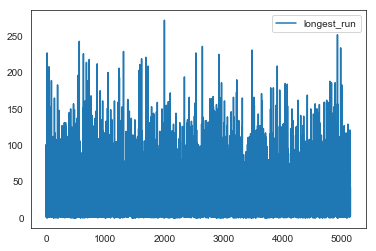

In [8]:
df2.plot()

In [9]:
df2.describe()

,longest_run
count,5149.000000
mean,37.675277
std,40.054123
min,0.000000
25%,6.000000
50%,23.000000
75%,59.000000
max,272.000000


### Define and compute at least 3 features based on the first 30 days of usage for each member. Motivate the use of each feature. These will be used in the next part.

I chose to compute usage during the first, second, and third week as a customer. 

In [10]:
# First week usage

df3 = df[df['day']<7].drop(columns=['day'])
df3 = df3.groupby(['user']).sum()

df3.describe()

,usage
count,1416.000000
mean,1.656780
std,1.266361
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,7.000000


In [11]:
# Second Week Usage

df4 = df[(df['day']<14) & (df['day']>6)].drop(columns=['day'])
df4 = df4.groupby(['user']).sum()

df4.describe()

,usage
count,2383.000000
mean,3.492656
std,2.373201
min,0.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,7.000000


In [12]:
# Third Week Usage

df5 = df[(df['day']<21) & (df['day']>13)].drop(columns=['day'])
df5 = df5.groupby(['user']).sum()

df5.describe()

,usage
count,2657.000000
mean,3.339104
std,2.535996
min,0.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,7.000000


### Based on the first 30 days of usage for each member and the features created in part 2, build a predictive model of churn (defined as at least 30 days of inactivity following the first 30 days of usage). For example someone who has been a user for 60 days and has had no activity in the last 30 days has churned, but if they had only been a member for 59 days then they cannot be churned yet even if they have not had activity in the last 30 days.

#### Train and describe the model
#### Provide evidence of its performance
#### Which of your features is important / influential in the model?


In [13]:
#Get Target outcomes; 1 - if churned, 0 - if not

labels_df = df[(df['day']>29) & (df['day']<60)]

print(labels_df.head(30))

labels_df = labels_df.drop(columns=['day'])
labels_df = labels_df.groupby(['user']).sum()

labels_df.reset_index(inplace=True)


labels_df['label'] = labels_df['usage'].apply(lambda x: 1 if x == 0 else 0)

print(labels_df.head(30))

                                        user  day  usage
30  00097b5304ac028d14ec093cba2c41f76126fab4   30      0
31  00097b5304ac028d14ec093cba2c41f76126fab4   31      0
32  00097b5304ac028d14ec093cba2c41f76126fab4   32      0
33  00097b5304ac028d14ec093cba2c41f76126fab4   33      0
34  00097b5304ac028d14ec093cba2c41f76126fab4   34      0
35  00097b5304ac028d14ec093cba2c41f76126fab4   35      0
36  00097b5304ac028d14ec093cba2c41f76126fab4   36      0
37  00097b5304ac028d14ec093cba2c41f76126fab4   37      0
38  00097b5304ac028d14ec093cba2c41f76126fab4   38      0
39  00097b5304ac028d14ec093cba2c41f76126fab4   39      0
40  00097b5304ac028d14ec093cba2c41f76126fab4   40      0
41  00097b5304ac028d14ec093cba2c41f76126fab4   41      0
42  00097b5304ac028d14ec093cba2c41f76126fab4   42      0
43  00097b5304ac028d14ec093cba2c41f76126fab4   43      0
44  00097b5304ac028d14ec093cba2c41f76126fab4   44      0
45  00097b5304ac028d14ec093cba2c41f76126fab4   45      0
46  00097b5304ac028d14ec093cba2

In [14]:
df3.reset_index(inplace=True)
df3.columns=['user','usage_week1']

df4.reset_index(inplace=True)
df4.columns=['user','usage_week2']

df5.reset_index(inplace=True)
df5.columns=['user','usage_week3']



In [15]:
print(df3.head())
print(df4.head())
print(df5.head())


train_df = labels_df.merge(df3,how='left',left_on='user',right_on='user')
train_df = train_df.merge(df4,how='left',left_on='user',right_on='user')
train_df = train_df.merge(df5,how='left',left_on='user',right_on='user')

train_df.head()

                                       user  usage_week1
0  00097b5304ac028d14ec093cba2c41f76126fab4            0
1  0036892c09cc30ab1dec9999eb43189af4dd71b4            2
2  00a78f39b2e295511861f850fd615747da093f5e            0
3  00d0419cab864fe884a4b3d75afa7c11b4a6727d            3
4  00e4191778b0639adfec27c256e615cc033a22a3            0
                                       user  usage_week2
0  00097b5304ac028d14ec093cba2c41f76126fab4            0
1  0036892c09cc30ab1dec9999eb43189af4dd71b4            7
2  004ac21e94c7a42e6c93835062602402056f2443            0
3  00a78f39b2e295511861f850fd615747da093f5e            0
4  00d0419cab864fe884a4b3d75afa7c11b4a6727d            5
                                       user  usage_week3
0  00097b5304ac028d14ec093cba2c41f76126fab4            0
1  0036892c09cc30ab1dec9999eb43189af4dd71b4            7
2  004ac21e94c7a42e6c93835062602402056f2443            7
3  00a78f39b2e295511861f850fd615747da093f5e            1
4  00c488b6d8b19ae9fa04d16f0146

,user,usage,label,usage_week1,usage_week2,usage_week3
0,00097b5304ac028d14ec093cba2c41f76126fab4,1,0,0.0,0.0,0.0
1,002b862b2604247ecfe7c9dc9d5fa41811a93d3e,12,0,NaN,NaN,NaN
2,0036892c09cc30ab1dec9999eb43189af4dd71b4,29,0,2.0,7.0,7.0
3,0040b11703e9dd8d7c8e5b8b46f64d20b642eb71,0,1,NaN,NaN,NaN
4,004ac21e94c7a42e6c93835062602402056f2443,15,0,NaN,0.0,7.0


Accuracy Score:  0.8925729442970822


Params:  <bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)>




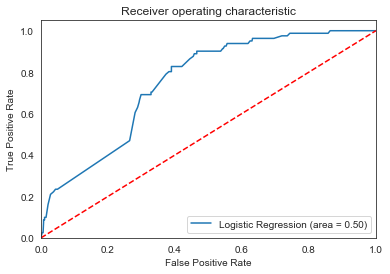

In [16]:
### Using SKleanr logistic Model
# 1 Hot Encoding



y = train_df['label']
X = train_df.drop(['label','user','usage'], axis = 1)
X = X.fillna(0)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X,y,random_state=5)




logreg = LogisticRegression()


# Fit the model on the trainng data.
logreg.fit(Xlr, ylr)
ylr_pred = logreg.predict(Xtestlr)

# Print the accuracy from the testing data.
print("Accuracy Score: ", accuracy_score(logreg.predict(Xtestlr), ytestlr))
print("\n")
print("Params: ", logreg.get_params)
print("\n")


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(ytestlr, logreg.predict(Xtestlr))
fpr, tpr, thresholds = roc_curve(ytestlr, logreg.predict_proba(Xtestlr)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()